## Results for HOSP dataset

In [1]:
from data import HOSPData
import matplotlib.pyplot as plt
import pandas as pd
from modelGen import modelGen
from metrics import mae, nep,eac
from address import get_model_path
%matplotlib inline

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import numpy as np
output_notebook()

2023-12-12 13:13:56.765051: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Loading BokehJS ...

Reading data and processing test data

In [2]:
dataGen = HOSPData(path="./data/")
trainMain,trainTargets, trainStates = dataGen.get_train_sequences(start = "2018-05-01",
                                                                  end="2019-02-28")
testMain,testTargets, testStates = dataGen.get_test_sequences(start = "2018-04-01",
                                                              end="2018-05-01",
                                                              norm=False)

data= {"X_train":trainMain,
        "Y_train":trainTargets,
        "Y_states":trainStates,
        "Z_train":trainStates,
        "X_test":testMain,
        "Y_test":testTargets,
        "Z_test":testStates,
        "app_data":dataGen.get_app_data(),
        "main_data": dataGen.get_main_mean_std()
        } 

In [3]:
MODELSID = ["dAE","biLSTM","FCNdAE","UNET","multiFCNdAE"]
APP_LABELS = list(data["app_data"].keys())
SCORES = []
MODELS = []
METRICS = [mae,eac]
METRICS_LAB = ["MAE","NEP","EAC"]

for modelID in MODELSID:
    MODELS.append(modelGen(modelID=modelID,data=data, params = {"sequence_length":1440}))
    MODELS[-1].load(get_model_path("HOSP",modelID))
    mtrc = MODELS[-1].evaluate(data["X_test"],
                                data["Y_test"],
                                data["Z_test"],
                                metrics=METRICS)
    
    SCORES+=mtrc

Building model
FCNdAE
multiFCNdAE
multiUNET
UNET
dAE
Building model: dAE [keras]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1440, 8)           40        
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 11520)             132721920 
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               1474688   
                                                                 
 dense_2 (Dense)             (None, 11520)             1486080   
                                         

2023-12-12 13:14:02.536712: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 13:14:02.796037: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22311 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


restoring weights of model dAE from path: /home/diego/repositorios/NCA23_nilm/results/HOSP/dAE/dAE_X-ray
restoring weights of model dAE from path: /home/diego/repositorios/NCA23_nilm/results/HOSP/dAE/dAE_Rehab
restoring weights of model dAE from path: /home/diego/repositorios/NCA23_nilm/results/HOSP/dAE/dAE_Data Center
restoring weights of model dAE from path: /home/diego/repositorios/NCA23_nilm/results/HOSP/dAE/dAE_Floors


2023-12-12 13:14:06.146277: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 0s 38ms/step


2023-12-12 13:14:06.848403: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 39ms/step
Building model
FCNdAE
multiFCNdAE
multiUNET
UNET
dAE
biLSTM
Building model: biLSTM [keras]
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 1441, 16)          80        
                                                                 
 bidirectional (Bidirectiona  (None, 1441, 256)        148480    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1050624   
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 128)               65664     
                                                                 
 dense_16 (Dense)            (None, 1)     

In [4]:
scores_df = pd.DataFrame(data=SCORES,columns = ["APP","SCORE","METRIC","MODEL"])
table_metrics_single = pd.pivot_table(scores_df, values='SCORE', index=['METRIC', 'MODEL'],columns=['APP'],sort=False)
table_metrics_single

APP                 Data Center    Floors     Lifts     Rehab      X-ray
METRIC MODEL                                                            
mae    dAE             2.784936  1.760227  1.831942  1.098438  10.341452
       biLSTM          2.701246  1.911887  2.372333  1.134561   6.676396
       FCNdAE          0.998938  1.284582  1.694803  0.768039   4.096596
       UNET            0.850584  2.500857  3.187586  1.330402   4.765751
       multiFCNdAE     0.299532  1.134963  1.539787  0.702924   3.045109
eac    dAE             0.974897  0.972038  0.973784  0.973348   0.823617
       biLSTM          0.975651  0.969629  0.966050  0.972471   0.886128
       FCNdAE          0.990996  0.979594  0.975746  0.981364   0.930129
       UNET            0.992333  0.960273  0.954384  0.967719   0.918716
       multiFCNdAE     0.997300  0.981971  0.977965  0.982944   0.948063

In [5]:
print(table_metrics_single.to_latex(float_format="%2.3f",multirow=True))

\begin{tabular}{llrrrrr}
\toprule
    & APP &  Data Center &  Floors &  Lifts &  Rehab &  X-ray \\
METRIC & MODEL &              &         &        &        &        \\
\midrule
\multirow{5}{*}{mae} & dAE &        2.785 &   1.760 &  1.832 &  1.098 & 10.341 \\
    & biLSTM &        2.701 &   1.912 &  2.372 &  1.135 &  6.676 \\
    & FCNdAE &        0.999 &   1.285 &  1.695 &  0.768 &  4.097 \\
    & UNET &        0.851 &   2.501 &  3.188 &  1.330 &  4.766 \\
    & multiFCNdAE &        0.300 &   1.135 &  1.540 &  0.703 &  3.045 \\
\cline{1-7}
\multirow{5}{*}{eac} & dAE &        0.975 &   0.972 &  0.974 &  0.973 &  0.824 \\
    & biLSTM &        0.976 &   0.970 &  0.966 &  0.972 &  0.886 \\
    & FCNdAE &        0.991 &   0.980 &  0.976 &  0.981 &  0.930 \\
    & UNET &        0.992 &   0.960 &  0.954 &  0.968 &  0.919 \\
    & multiFCNdAE &        0.997 &   0.982 &  0.978 &  0.983 &  0.948 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1112347/1696693913.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_metrics_single.to_latex(float_format="%2.3f",multirow=True))


## Visualiazing single-target results

In [6]:
n_samples = 600*24*7 # 1 week of data
disagg_est = [model.predict(data["X_test"][:n_samples]) for model in MODELS]
disagg    = [ data["Y_test"][ii][:n_samples] for ii,app in enumerate(dataGen.get_app_data().keys())]


1/1 [==============================] - 0s 9ms/step


9/9 [==============================] - 0s 48ms/step


0-dAE-Lifts
1-dAE-X-ray
2-dAE-Rehab
3-dAE-Data Center
4-dAE-Floors
5-biLSTM-Lifts
6-biLSTM-X-ray
7-biLSTM-Rehab
8-biLSTM-Data Center
9-biLSTM-Floors
10-FCNdAE-Lifts
11-FCNdAE-X-ray
12-FCNdAE-Rehab
13-FCNdAE-Data Center
14-FCNdAE-Floors
15-UNET-Lifts
16-UNET-X-ray
17-UNET-Rehab
18-UNET-Data Center
19-UNET-Floors
20-multiFCNdAE-Lifts
21-multiFCNdAE-X-ray
22-multiFCNdAE-Rehab
23-multiFCNdAE-Data Center
24-multiFCNdAE-Floors


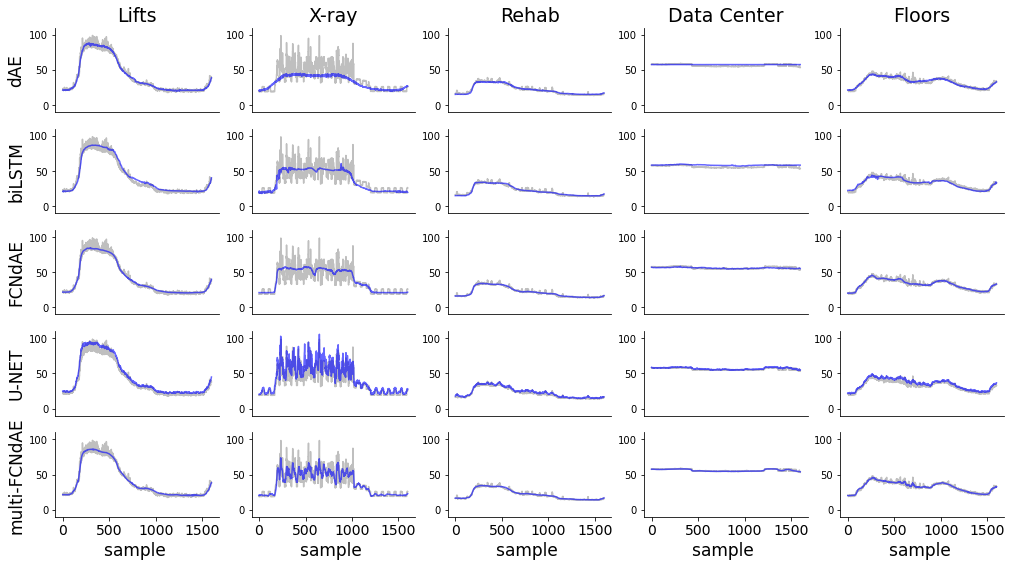

: 

In [7]:
from itertools import product
MODELLABELS = ["dAE","biLSTM","FCNdAE","U-NET","multi-FCNdAE"]
rows = len(MODELS)
columns = len(data["app_data"].keys())
# Selected idxs
start = [4500]*len(APP_LABELS)
stop  = [6100]*len(APP_LABELS)
plt.figure("Results UKDALE",figsize=(17,9))
plt.clf()
for ii,(model,app) in enumerate(product(range(rows),range(columns))):
    print(f"{ii}-{MODELSID[model]}-{APP_LABELS[app]}")
    ax =plt.subplot(rows,columns, ii+1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    
    plt.plot(disagg[app][start[app]:stop[app]],c="gray",alpha=0.5, label="Ground truth")
    plt.plot(disagg_est[model][app][start[app]:stop[app]],c="blue",alpha=0.6, label="Ground truth")
    ax.set_ylim(-10,110)
    ## Labels
    if model ==0:
       ax.set_title(f"{APP_LABELS[app]}",fontdict={'fontsize':19}) 
    if app  ==0:
        ax.set_ylabel(MODELLABELS[model],fontdict={'fontsize':17})
    if model == rows-1:
        plt.xticks(fontsize=14)
        plt.xlabel("sample ",fontdict={'fontsize':17})
    else:
        ax.set_xticks([])

0-dAE-Lifts
1-dAE-X-ray
2-dAE-Rehab
3-dAE-Data Center
4-dAE-Floors
5-biLSTM-Lifts
6-biLSTM-X-ray
7-biLSTM-Rehab
8-biLSTM-Data Center
9-biLSTM-Floors
10-FCNdAE-Lifts
11-FCNdAE-X-ray
12-FCNdAE-Rehab
13-FCNdAE-Data Center
14-FCNdAE-Floors
15-multiFCNdAE-Lifts
16-multiFCNdAE-X-ray
17-multiFCNdAE-Rehab
18-multiFCNdAE-Data Center
19-multiFCNdAE-Floors


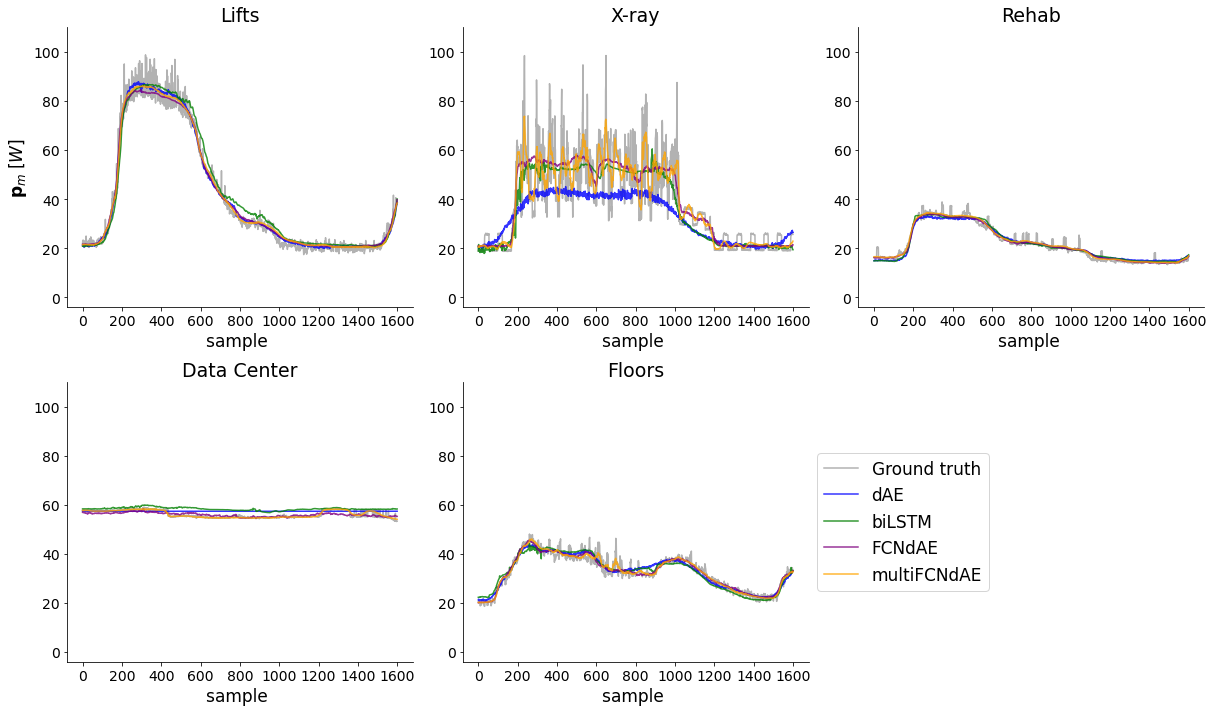

In [7]:
from itertools import product

rows = 1
columns = len(data["app_data"].keys())
# Selected idxs
start = [4500]*len(APP_LABELS)
stop  = [6100]*len(APP_LABELS)
colors = ["blue","green","purple","orange"]
plt.figure("Results single-target UKDALE",figsize=(17,10))
plt.clf()
for ii,(model,app) in enumerate(product(range(len(MODELS)),range(columns))):
    print(f"{ii}-{MODELSID[model]}-{APP_LABELS[app]}")
    ax =plt.subplot(2,3, ii%columns+1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    
    ## Labels
    if model ==0:
       ax.set_title(f"{APP_LABELS[app]}",fontdict={'fontsize':19}) 
       plt.plot(disagg[app][start[app]:stop[app]],c="black",alpha=0.3, linewidth=1.5, label="Ground truth")
       plt.xticks(fontsize=14)
       plt.yticks(fontsize=14)
       plt.xlabel("sample ",fontdict={'fontsize':17})
       plt.ylim(-4,110)

    if app  ==0:
        ax.set_ylabel(r"$ \mathbf{p}_m \; [W]$",fontdict={'fontsize':17})
    plt.plot(disagg_est[model][app][start[app]:stop[app]],c=colors[model],linewidth=1.5,alpha=0.8, label=MODELSID[model])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.tight_layout()
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=17)

## MULTI-TARGET RESULTS

In [21]:
MODELSID = ["multiFCNdAE","UNET"]
#MODELSID = ["multiUNET"]
APP_LABELS = list(data["app_data"].keys())
SCORES = []
MODELS = []
METRICS = [mae,eac]
METRICS_LAB = ["MAE","NEP","EAC"]

for modelID in MODELSID:
    MODELS.append(modelGen(modelID=modelID,data=data, params = {"sequence_length":1440}))
    MODELS[-1].load(get_model_path("HOSP",modelID))
    mtrc = MODELS[-1].evaluate(data["X_test"],
                                data["Y_test"],
                                data["Z_test"],
                                metrics=METRICS)
    
    SCORES+=mtrc

Building model
FCNdAE
multiFCNdAE
Building model: <bound method multiFCNdAE.get_model_name of <class 'models.multiFCNdAE.multiFCNdAE'>> [<bound method multiFCNdAE.get_model_type of <class 'models.multiFCNdAE.multiFCNdAE'>>]
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mod_input (InputLayer)         [(None, 5)]          0           []                               
                                                                                                  
 FiLM_GEN_1 (Dense)             (None, 32)           192         ['mod_input[0][0]']              
                                                                                                  
 FiLM_GEN_act_1 (LeakyReLU)     (None, 32)           0           ['FiLM_GEN_1[0][0]']             
                                                                  

restoring weights of model multiFCNdAE from path: /home/diego/repositorios/NCA23_nilm/results/HOSP/multiFCNdAE/multiFCNdAE
73/73 [==============================] - 2s 31ms/step
Building model
FCNdAE
multiFCNdAE
multiUNET
UNET
Building model: UNET [keras]
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 1440, 1)]    0           []                               
                                                                                                  
 con1D (Conv1D)                 (None, 1440, 16)     128         ['main_input[0][0]']             
                                                                                                  
 conv_0 (Conv1D)                (None, 720, 32)      1696        ['con1D[0][0]']                  
                                   

In [22]:

scores_df = pd.DataFrame(data=SCORES,columns = ["APP","SCORE","METRIC","MODEL"])
table_metrics = pd.pivot_table(scores_df, values='SCORE', index=['METRIC', 'MODEL'],columns=['APP'],sort=False)
table_metrics

APP                 Data Center    Floors     Lifts     Rehab     X-ray
METRIC MODEL                                                           
mae    multiFCNdAE     0.306926  1.151114  1.546870  0.742973  3.289763
       UNET            0.850584  2.500857  3.187586  1.330402  4.765751
eac    multiFCNdAE     0.997233  0.981714  0.977863  0.981973  0.943890
       UNET            0.992333  0.960273  0.954384  0.967719  0.918716

In [23]:
print(table_metrics.to_latex())

\begin{tabular}{llrrrrr}
\toprule
    & APP &  Data Center &    Floors &     Lifts &     Rehab &     X-ray \\
METRIC & MODEL &              &           &           &           &           \\
\midrule
mae & multiFCNdAE &     0.306926 &  1.151114 &  1.546870 &  0.742973 &  3.289763 \\
    & UNET &     0.850584 &  2.500857 &  3.187586 &  1.330402 &  4.765751 \\
eac & multiFCNdAE &     0.997233 &  0.981714 &  0.977863 &  0.981973 &  0.943890 \\
    & UNET &     0.992333 &  0.960273 &  0.954384 &  0.967719 &  0.918716 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_963170/321211578.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_metrics.to_latex())


## Visualizing the disaggregations

In [24]:
n_samples = 600*24*7 # 1 week of data
disagg_est = [model.predict(data["X_test"][:n_samples]) for model in MODELS]
disagg    = [ data["Y_test"][ii][:n_samples] for ii,app in enumerate(dataGen.get_app_data().keys())]
# colors = ["blue","green","orange","purple"]
# figs = [figure(title=f"Results {app}",width=900,height=350) for app in dataGen.get_app_data().keys()]
# for jj, model in enumerate(MODELSID):
#     for ii,app in enumerate(dataGen.get_app_data().keys()):
#         p = figs[ii] 
#         app_target_est = disagg_est[jj][ii]                
#         p.line(np.arange(len(app_target_est)), app_target_est, line_color=colors[jj],line_alpha=0.4, legend_label=f"{model}")


# for ii,app in enumerate(dataGen.get_app_data().keys()):
#     p = figs[ii] 
#     app_target = disagg[ii]
#     p.line(np.arange(len(app_target)), app_target, line_color="gray",line_alpha=0.4, legend_label="Ground truth")
#     show(p)

90/90 [==============================] - 3s 39ms/step


0-multiFCNdAE-Lifts
1-multiFCNdAE-X-ray
2-multiFCNdAE-Rehab
3-multiFCNdAE-Data Center
4-multiFCNdAE-Floors
5-UNET-Lifts
6-UNET-X-ray
7-UNET-Rehab
8-UNET-Data Center
9-UNET-Floors


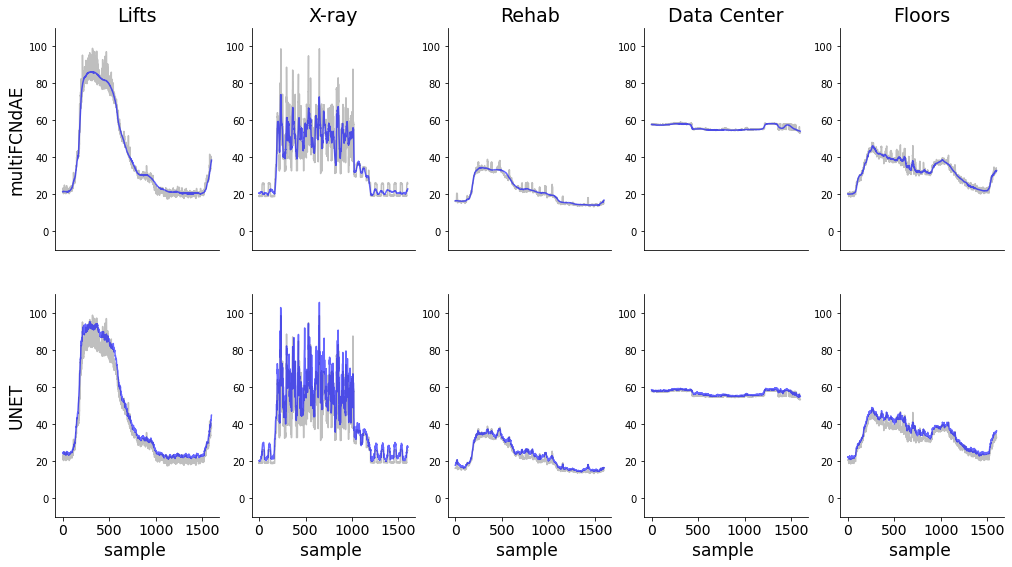

: 

In [27]:
from itertools import product

rows = len(MODELS)
columns = len(data["app_data"].keys())
# Selected idxs
start = [4500]*len(APP_LABELS)
stop  = [6100]*len(APP_LABELS)
plt.figure("Results UKDALE",figsize=(17,9))
plt.clf()
for ii,(model,app) in enumerate(product(range(rows),range(columns))):
    print(f"{ii}-{MODELSID[model]}-{APP_LABELS[app]}")
    ax =plt.subplot(rows,columns, ii+1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    
    plt.plot(disagg[app][start[app]:stop[app]],c="gray",alpha=0.5, label="Ground truth")
    plt.plot(disagg_est[model][app][start[app]:stop[app]],c="blue",alpha=0.6, label="Ground truth")
    ax.set_ylim(-10,110)
    ## Labels
    if model ==0:
       ax.set_title(f"{APP_LABELS[app]}",fontdict={'fontsize':19}) 
    if app  ==0:
        ax.set_ylabel(MODELSID[model],fontdict={'fontsize':17})
    if model == rows-1:
        plt.xticks(fontsize=14)
        plt.xlabel("sample ",fontdict={'fontsize':17})
    else:
        ax.set_xticks([])